In [1]:
import sys
sys.path.append('../src')
from PIL import Image
import matplotlib.pyplot as plt

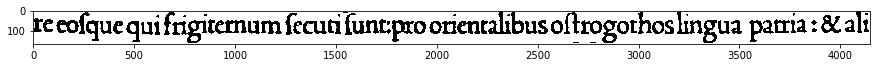

re eoſque qui frigiternum ſecuti ſunt: pro orientalibus oſtrogothos lingua patria: & ali


In [2]:
SOURCE = "C:\\Users\\Abd\\Desktop\\PML\\corpus\\EarlyModernLatin\\EarlyModernLatin\\"
image_path = SOURCE + "1483-Decades-Biondo\\00512.bin.png";
text_path = SOURCE + "1483-Decades-Biondo\\00512.gt.txt";

# image_path = "/home/space/datasets/text/GT4HistOCR/EarlyModernLatin/1564-Thucydides-Valla/01928.bin.png";
# text_path = "/home/space/datasets/text/GT4HistOCR/EarlyModernLatin/1564-Thucydides-Valla/01928.gt.txt";

# image_path = "/home/space/datasets/text/GT4HistOCR/EarlyModernLatin/1564-Thucydides-Valla/01930.bin.png";
# text_path = "/home/space/datasets/text/GT4HistOCR/EarlyModernLatin/1564-Thucydides-Valla/01930.gt.txt";

image = Image.open(image_path)
image = image.convert('1')
with open(text_path,encoding = 'utf-8') as f:
    text = f.read().rstrip()

plt.figure(figsize=(15, 8))
plt.imshow(image)
plt.show()
print(text)

In [3]:
from ocr_latin_model_predict import predict

result,confidence, _ = predict(image)
print("predicted text:", result)
print("confidence:", confidence)

predicted text: re eoſque quifrigitermum ſecuti ſunt:pro orientalibus oſtrogothos lingua patria: &ali
confidence: 0.84587824


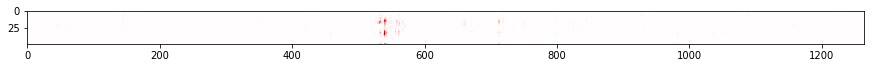

In [3]:
import torch
from ocr_model import OCRModel
from ocr_image_transformations import *
from torchvision import transforms
from ocr_utils import *
from scipy.stats import entropy

MODEL_PATH = '../models/Latin_model.pth'
ALPHA_PATH = '../models/Latin_alphabet.pth'

model = OCRModel(50, 150, 2, 181)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
model.eval()

alphabet = torch.load(ALPHA_PATH)

transformations = transforms.Compose([
    FixLineImage(),
    ImageThumbnail(50, 100000),
    transforms.ToTensor(),
    UnfoldImage(1, 1)
])


t_img = transformations(image)
t_img = t_img.reshape((1, t_img.shape[0], t_img.shape[1]))


explain(t_img, model)

In [5]:
import glob
from ocr_model import OCRModel
import re
from Levenshtein import distance, editops
from ocr_confusion_matrix import pretty_plot_confusion_matrix
from pandas import DataFrame
from ocr_model import OCRModel
import torch
from ocr_model import OCRModel
from ocr_image_transformations import *
from torchvision import transforms
from ocr_utils import *
from scipy.stats import entropy

MODEL_PATH = '../models/Latin_model.pth'
ALPHA_PATH = '../models/Latin_alphabet.pth'

model = OCRModel(50, 150, 2, 181)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
model.eval()

alphabet = torch.load(ALPHA_PATH)

transformations = transforms.Compose([
    FixLineImage(),
    ImageThumbnail(50, 100000),
    transforms.ToTensor(),
    UnfoldImage(1, 1)
])


holdout = SOURCE + '1483-Decades-Biondo'
image_files_names = glob.glob(holdout + "\\*.png")

fl=0
confusion_matrix = np.zeros((len(alphabet), len(alphabet)))
for image_file in image_files_names:
    image = Image.open(image_file)
    image = image.convert('1')
    
    match = re.match("(.*\\\\\d+).*(\.png)", image_file)
    text_file = match.group(1) + '.gt.txt'
    with open(text_file,encoding = 'utf-8') as f:
        true_text = f.read().rstrip()
    
    t_img = transformations(image)
    t_img = t_img.reshape((1, t_img.shape[0], t_img.shape[1]))
    output = model(t_img).detach().numpy()
    predicted_text = prob2text(output, alphabet)[0]
    predicted_text = clean_text(predicted_text)
#     print(true_text)
#     print(predicted_text)
    cp_predicted_text =  (predicted_text + '.')[:-1]
    cp_true_text =  (true_text + '.')[:-1]
    edits = editops(predicted_text, true_text)
    for edit in reversed(edits):
        op = edit[0]
        predict_char_pos = edit[1]
        true_char_pos = edit[2]
        if op == 'delete':
            cp_true_text = cp_true_text[:true_char_pos] + '$' + cp_true_text[true_char_pos:]
            continue
        if op == 'insert':
            cp_predicted_text = cp_predicted_text[:predict_char_pos] + '$' + cp_predicted_text[predict_char_pos:]
            continue
#     print('==========')
#     print(cp_true_text)
#     print(cp_predicted_text)
    for i in range(len(cp_true_text)):
        true_char = np.argwhere(alphabet == cp_true_text[i]).flatten()[0]
        predicted_char = np.argwhere(alphabet == cp_predicted_text[i]).flatten()[0]
        confusion_matrix[predicted_char][true_char] +=1
#     print()
#     print('==============================================================================')
#     print()
    fl += 1
    print(fl)


df_cm = DataFrame(confusion_matrix, index=[i for i in alphabet], columns=[i for i in alphabet])
#colormap: see this and choose your more dear
cmap = 'PuRd'
pretty_plot_confusion_matrix(df_cm, cmap=cmap, figsize=[200,200])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


C:\Users\Abd\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 7633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Abd\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 7635 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Abd\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 7651 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Abd\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 11799 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Abd\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 42840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Abd\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 42841 missing from current font.
  

In [7]:
import math
    
tp = np.diag(confusion_matrix) # True positive
fp = confusion_matrix.sum(axis=0) - tp # False positive
fn = confusion_matrix.sum(axis=1) - tp # False negative
tn = confusion_matrix.trace() - tp # True negative

accuracy = (tp + tn)/ (tp + tn + fp + fn)
recall = tp/ (tp + fn)
precision = tp / (tp + fp)

chars = { char : i for i,char in enumerate(alphabet) }
for char, i in chars.items():
    if math.isnan(precision[i]) or math.isnan(recall[i]):
        continue
    print(f'{char} : Accuracy {format(accuracy[i], ".2f")} - Recall {format(recall[i], ".2f")} - Precision {format(precision[i], ".2f")}')
          


C:\Users\Abd\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\Abd\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


$ : Accuracy 0.96 - Recall 0.00 - Precision 0.00
  : Accuracy 0.98 - Recall 0.98 - Precision 0.85
& : Accuracy 1.00 - Recall 0.95 - Precision 0.92
- : Accuracy 1.00 - Recall 0.93 - Precision 0.49
. : Accuracy 1.00 - Recall 0.88 - Precision 0.73
: : Accuracy 0.99 - Recall 0.96 - Precision 0.57
; : Accuracy 1.00 - Recall 0.85 - Precision 0.92
? : Accuracy 1.00 - Recall 0.12 - Precision 1.00
A : Accuracy 1.00 - Recall 0.95 - Precision 0.93
B : Accuracy 1.00 - Recall 0.82 - Precision 0.47
C : Accuracy 1.00 - Recall 0.98 - Precision 0.71
D : Accuracy 1.00 - Recall 0.75 - Precision 0.69
E : Accuracy 1.00 - Recall 0.89 - Precision 0.85
F : Accuracy 1.00 - Recall 0.67 - Precision 0.67
G : Accuracy 1.00 - Recall 0.90 - Precision 0.90
H : Accuracy 1.00 - Recall 0.86 - Precision 0.86
I : Accuracy 1.00 - Recall 0.88 - Precision 0.60
L : Accuracy 1.00 - Recall 0.74 - Precision 0.64
M : Accuracy 1.00 - Recall 0.93 - Precision 0.77
N : Accuracy 1.00 - Recall 0.95 - Precision 0.93
O : Accuracy 1.00 - 

In [6]:
np.save('confusion_mat.np', confusion_matrix)